# Análise de Sentimento - Bag of Words Meets Bag of Popcorn

O presente projeto foi realizado para a disciplina Programação para Aprendizagem de Máquina, da pós graduação em Ciência de Dados da Universidade Federal de Pernambuco.

Foi utilizada a base de dados da competição do Kaggle "Bag of words meet bags of popcorns", que contém 50.000 comentários a respeito de filmes no site do IMDb. Os comentários são divididos em 2 grupos: os que foram acompanhados de notas inferiores a 5 estrelas -rotulados como 0- são de comentários com sentimento negativo a respeito do filme, os que foram acompanhados de notas superiores a 7 -rotulados com 1- são comentários com sentimento positivo.

O objetivo do projeto criar um modelo para prever o sentimento do comentário.

## Preparando o ambiente

In [ ]:
# Código para o Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
#Importando bibliotecas relevantes

import pandas as pd #Biblioteca para visualização e manipulação de dataframes
import numpy as np #Biblioteca com métodos matemáticos como geração aleatória de números, algebra linear, etc

#Bibliotecas gráficas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

import nltk #Biblioteca para processamento simbólico e estatístico de linguagem natural
from nltk.corpus import stopwords

from tqdm import tqdm #Biblioteca para visualização do processamos de uma iteração

In [ ]:
#Importando base de dados
train = pd.read_csv('labeledTrainData.tsv',sep='\t')

train.review = [x.replace(".","").replace(",","").replace("!","").
                replace("(","").replace(")","").replace("?","").
                replace("<br","").replace("<","").replace("\t","")
                .replace(">","").replace("...","").replace("\\","").replace("\"","") for x in train.review]

train.review

test = pd.read_csv('testData.tsv',sep='\t')
test.review = [x.replace(".","").replace(",","").replace("!","").
                replace("(","").replace(")","").replace("?","").
                replace("<br","").replace("<","").replace("\t","")
                .replace(">","").replace("...","").replace("\\","").replace("\"","") for x in test.review]



In [ ]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,The Classic War of the Worlds by Timothy Hines...
2,7759_3,0,The film starts with a manager Nicholas Bell g...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [ ]:
train.shape

(25000, 3)

## Metodologia

O modelo selecionado para o projeto foi o Naive Bayes Classifier. Esse classificador usa a regra de Bayes para prever o output (sentimento positivo ou negativo) do modelo, dadas as informações do review, conforme descrito abaixo:
<br />

$       P(sentimento | palavra) = \frac{P(palavra | sentimento)*P(sentimento)}{P(palavra)}$


Em resumo, será contado o uso de palavras nos reviews resultados em cada sentimento e determinada uma probabilidade de cada palavra estar relacionada a um sentimento negativo ou positivo. 

Um ponto negativo do modelo, importante destacar é que ele não considera a interação entre palavras nem a ordem de aparecimento das mesmas.

## Implementação

Inicialmente, será realizada a limpeza e tratamento dos dados. Nesse processo, as reviews foram separadas em palavras individuis excluindo stopword (ou seja, palavras vazias, que o significado não são relevantes para a análise de sentimento do texto).

Todas as pontuações foram excluídas e as palavras foram colocadas em letra minúscula, para que palavras no iníicio de frase não sejam diferenciadas.

Para o modelo, serão usadas as 2.000 palavras mais comuns.

In [ ]:
#!python -m nltk.downloader all

stop_words = set(stopwords.words('english')) #Lista de palavras vazias
words = []

#Criando lista com palavras mais frequentes, excluindo palavras vazias
for n in tqdm([s for s in train.review.str.split(' ')]):
    for w in n:
        if (w not in stop_words) & (w != ''):
            words.append(str.lower(w))
        else:
            pass

import string
table = str.maketrans('', '', string.punctuation) 
words = [w.translate(table) for w in words] #excluindo pontuação

all_words = nltk.FreqDist(words)
del all_words['']
word_features = list(all_words)[:2000]

É possível observar a lista de palavras mais comuns das reviews no gráfico abaixo. A maioria delas, aparentemente, não passa um sentimento claro em relação ao filme.

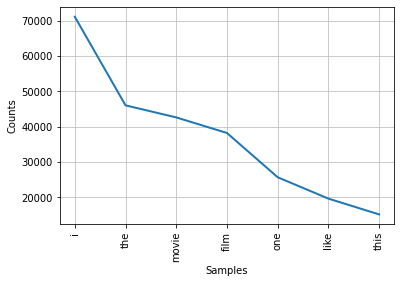

In [ ]:
all_words.plot(7)

In [ ]:
#Criando arquivo com o formato para o algoritmo
documents = []
for i in tqdm(range(len(train))):
    l=[]
    for s in train.review[i].split(' '):
        l.append(s)
    documents.append((l,train.sentiment[i]))

def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features
  
featuresets = [(document_features(d), c) for (d,c) in documents]

100%|██████████| 25000/25000 [00:02<00:00, 10401.16it/s]


In [ ]:
#Dividindo em base de treinamento e teste
train_set, test_set = featuresets[5000:], featuresets[:5000]

In [ ]:
# Treinando o modelo
classifier = nltk.NaiveBayesClassifier.train(train_set)

## Avaliando o modelo

In [ ]:
classifier.show_most_informative_features(10)

Most Informative Features
       contains(unfunny) = True                0 : 1      =     17.8 : 1.0
         contains(waste) = True                0 : 1      =     13.6 : 1.0
     contains(pointless) = True                0 : 1      =     11.9 : 1.0
     contains(redeeming) = True                0 : 1      =      9.9 : 1.0
         contains(worst) = True                0 : 1      =      8.9 : 1.0
     contains(laughable) = True                0 : 1      =      8.6 : 1.0
        contains(poorly) = True                0 : 1      =      8.4 : 1.0
         contains(awful) = True                0 : 1      =      8.4 : 1.0
   contains(wonderfully) = True                1 : 0      =      7.9 : 1.0
         contains(sucks) = True                0 : 1      =      7.5 : 1.0


O código acima traz as palavras que tem maior peso na tomada de decisão do modelo. Uma review que contém a palavra 'unfunny', por exemplo, tem a probabilidade 17,8 vezes maior de ser do grupo 0 (ter sentimento negativo) do que uma review sem essa palavra.

In [ ]:
print(nltk.classify.accuracy(classifier, test_set))

0.8302


O modelo conseguiu acertar o sentimento do review em 83,02% dos casos, quando usado na base de teste.